# Predict Covid cases by region

In [1]:
import pandas as pd 
import matplotlib.pyplot as mtp
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import requests
import awoc
import math

In [2]:
df = pd.read_csv("covid.csv",parse_dates=['last_updated'])
df.head()

df = df[df['new_infections'] >= 0]
df = df[df['new_deaths'] >=0]
df = df[df['new_recovered'] >=0]
df.head()

,Unnamed: 0,country,country_code,last_updated,new_deaths,new_infections,new_recovered
0,0,Afghanistan,AF,2020-02-25 00:00:00+00:00,0,0,0
1,1,Afghanistan,AF,2020-02-26 00:00:00+00:00,0,0,0
2,2,Afghanistan,AF,2020-02-27 00:00:00+00:00,0,0,0
3,3,Afghanistan,AF,2020-02-28 00:00:00+00:00,0,0,0
4,4,Afghanistan,AF,2020-02-29 00:00:00+00:00,0,0,0


## Bar plot for countries with most cases

### For some reason Namibia country code NA is converted to Nan. Filling it

In [3]:
df['country_code'].fillna("NA",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66005 entries, 0 to 66326
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0      66005 non-null  int64              
 1   country         66005 non-null  object             
 2   country_code    66005 non-null  object             
 3   last_updated    66005 non-null  datetime64[ns, UTC]
 4   new_deaths      66005 non-null  int64              
 5   new_infections  66005 non-null  int64              
 6   new_recovered   66005 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(2)
memory usage: 4.0+ MB


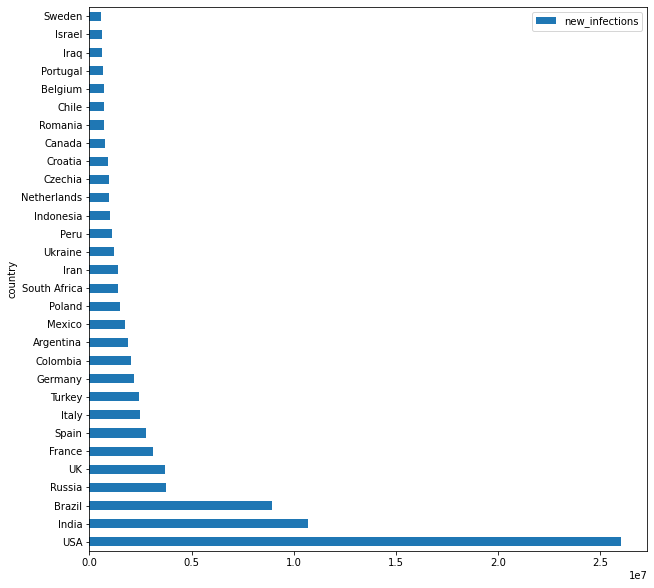

In [4]:
cases_per_country = pd.DataFrame( df.groupby("country")["new_infections"].agg(sum))
cases_sorted_asc = cases_per_country.sort_values("new_infections",ascending=False)[:30]
cases_sorted_asc.plot(kind='barh',figsize=(10,10));


<AxesSubplot:xlabel='last_updated'>

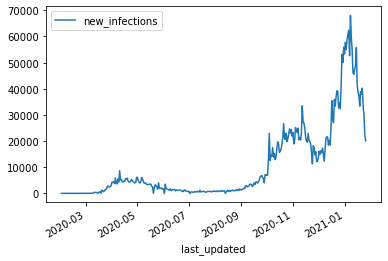

In [5]:
df.sort_values(by='last_updated')
df[df['country_code'] == 'GB'].plot(x="last_updated",y="new_infections")


In [6]:

def normalize_input_dataframe(dataframe):
    df_copy = dataframe.copy()
    df_copy['country_cat'] = df_copy['country_code'].astype('category').cat.codes
    df_copy['timestamp'] = [x.days for x in (df_copy['last_updated'] - df_date_sorted['last_updated'].min())]
    df_copy = df_copy.loc[:,['timestamp','country_cat','country_code']]
    return df_copy




## DecisionTreeRegressor test without any tuning/cross validation
We want to order the dataset by date so to have a ascendent order (chronological). Then we cut 10% from the bottom of the dataset to use as testing data (basically try to estimate the time series)

In [7]:
# sort by date
df_date_sorted = df.sort_values(by=['last_updated'])
df_date_sorted.reset_index(inplace=True,drop=True)
df_date_sorted

,Unnamed: 0,country,country_code,last_updated,new_deaths,new_infections,new_recovered
0,0,Taiwan,TW,2020-01-23 00:00:00+00:00,0,0,0
1,0,Thailand,TH,2020-01-23 00:00:00+00:00,0,1,0
2,0,South Korea,KR,2020-01-23 00:00:00+00:00,0,0,0
3,0,China,CN,2020-01-23 00:00:00+00:00,0,0,0
4,0,Hong Kong,HK,2020-01-23 00:00:00+00:00,0,2,0
...,...,...,...,...,...,...,...
66000,369,China,CN,2021-01-26 00:00:00+00:00,1,82,45
66001,316,Saint Lucia,LC,2021-01-26 00:00:00+00:00,2,35,9
66002,311,Saint Martin,MF,2021-01-26 00:00:00+00:00,0,0,0
66003,270,Comoros,KM,2021-01-26 00:00:00+00:00,1,75,17


In [8]:

#cut X and Ys 
X = df_date_sorted.drop(['new_deaths','new_infections','new_recovered'],1)
Y_Cases = df_date_sorted['new_infections']
Y_Fatalities = df_date_sorted['new_deaths']
#normalise input data for training
X_with_countries = normalize_input_dataframe(X)
X = X_with_countries.drop('country_code',1)
X_with_countries

,timestamp,country_cat,country_code
0,0,193,TW
1,0,187,TH
2,0,104,KR
3,0,39,CN
4,0,81,HK
...,...,...,...
66000,369,39,CN
66001,369,110,LC
66002,369,123,MF
66003,369,102,KM


In [67]:
#split train and test models for ConfirmedCases
X_cases_train,X_cases_test,Y_cases_train,Y_cases_test = train_test_split(X,Y_Cases,test_size=0.2, shuffle=True)
#split train and test models for Fatalities
X_fat_train,X_fat_test,Y_fat_train,Y_fat_test = train_test_split(X,Y_Fatalities,test_size=0.1,shuffle = True)
#training model and calculating sqrt mean squared log error on test set
model_cases = RandomForestRegressor(n_estimators = 400, bootstrap = True,max_depth = 50,max_features ='auto',
                                   min_samples_leaf=4,min_samples_split=10)
model_fatalities = RandomForestRegressor()

### Train and test model for Confirmed Cases

In [68]:
model_cases.fit(X_cases_train,Y_cases_train)
predictions = model_cases.predict(X_cases_test)
math.sqrt(mean_squared_log_error(Y_cases_test,predictions))

1.387630496467008

### Train and test model for Fatalities

In [11]:
model_fatalities.fit(X_fat_train,Y_fat_train)
predictions = model_fatalities.predict(X_fat_test)
math.sqrt(mean_squared_log_error(Y_fat_test,predictions))

0.8188085555080535

## Cross validation of DecisionTreeRegressor

In [12]:
X_with_countries[X_with_countries['country_code']=='GB']

,timestamp,country_cat,country_code
151,9,66,GB
172,10,66,GB
202,11,66,GB
220,12,66,GB
243,13,66,GB
...,...,...,...
64968,365,66,GB
65353,366,66,GB
65471,367,66,GB
65737,368,66,GB


In [70]:
gb_predictions = model_cases.predict([[i,66] for i in range(1,400)])

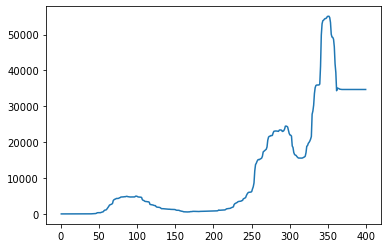

In [71]:
ranges = [i for i in range(1,400)]
mtp.plot(ranges,gb_predictions)

<AxesSubplot:xlabel='last_updated'>

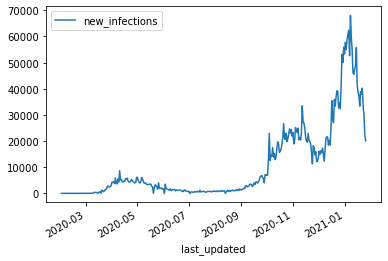

In [60]:
df.sort_values(by='last_updated')
df[df['country_code'] == 'GB'].plot(x="last_updated",y="new_infections")